# Example of usage

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

Install requierements

In [2]:
#!pip install xarray numpy ffmpeg scikit-image

Load required libraries

In [3]:
import xarray as xr
import numpy as np
from pathlib import Path
from xarrayvideo import xarray2video, video2xarray

Set up some variables and load an example minicube

In [4]:
#First, we unzip the example minicube
#!unzip cube.zip

In [5]:
array_id= '-111.49_38.60'
input_path= 'mc_-111.49_38.60_1.2.2_20230702_0.zarr'
output_path= './out'

minicube= xr.open_dataset(input_path, engine='zarr')
minicube['SCL']= minicube['SCL'].astype(np.uint8) #Fixes problem with the dataset
minicube= minicube.drop_vars('B07') #We drop a variable for now

In [6]:
minicube

<xarray.Dataset>
Dimensions:       (time: 495, y: 128, x: 128, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
Data variables: (12/37)
    B02           (time, y, x) float32 ...
    B03           (time, y, x) float32 ...
    B04           (time, y, x) float32 ...
    B05           (time, y, x) float32 ...
    B06           (time, y, x) float32 ...
    B8A           (time, y, x) float32 ...
    ...            ...
    t2m_max       (time) float32 ...
    t2m_mean      (time) float32 ...
    t2m_min       (time) float32 ...
    tp_max        (time) float32 ...
    tp_mean       (time) float32 ...
    tp_min        (time) float32 ...
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Fix the small jitter betweeen timesteps to improve compression

In [7]:
#Install satalign
#!pip install satalign

In [8]:
import satalign

bands= ['B04','B03','B02','B8A','B06','B05']
reference_image= minicube[bands].isel(time=slice(74,None)).mean("time").to_array().transpose('variable', 'y', 'x')
datacube= minicube[bands].to_array().transpose('time', 'variable', 'y', 'x')

syncmodel= satalign.PCC( #PCC quicker, ECC more precise
    datacube=datacube, # T x C x H x W
    reference=reference_image, # C x H x W
    channel="mean", crop_center=96, num_threads=1)
new_cube, warps= syncmodel.run_multicore()

/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/satalign/pcc.py:78: UserWarning: Could not determine RMS error between images with the normalized average intensities 9214516.0 and 0.0. Either the reference or moving image may be empty.
  shift, error, diffphase = phase_cross_correlation(
/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/satalign/main.py:227: UserWarning: Estimated translation is too large
  warnings.warn("Estimated translation is too large")


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

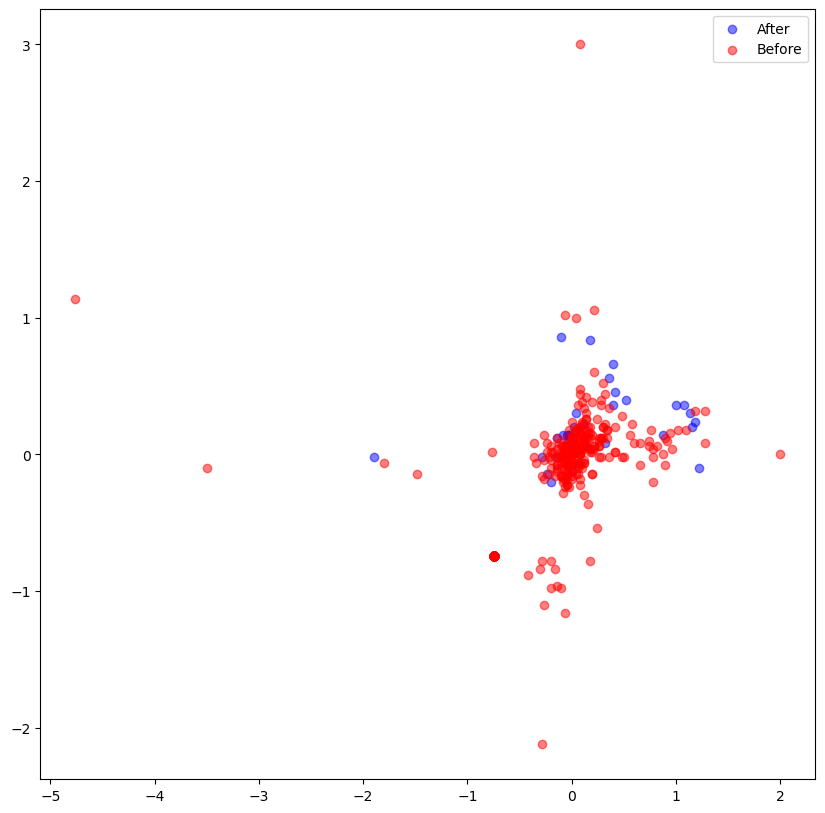

In [9]:
import matplotlib.pyplot as plt

# plot scatter plot
warp_df = satalign.utils.warp2df(warps, datacube.time.values)
satalign.utils.plot_s2_scatter(warp_df)

In [10]:
#Copy back
for b in bands:
    minicube[b]= new_cube.sel(variable=b)

Define conversion rules for the different bands. The syntax is:
```
'video_name': ( 
    var or (var1, var2, var3), #Variables present in the xarray
    (t_coord_name, x_coord_name, y_coord_name), #Names of the coordinates in order (t, x, y)
    'lossy' or 'lossless' #compression (e.g. lossless for uint8 masks)
    ),
...
```

In [11]:
#Define conversion rules for the different bands
conversion_rules= {
    # 'r': ( 'B04', ('time','x','y'), 'lossy'), #1 channel + lossy not working
    # 'ir4': ( ('B8A','B07','B06','B05'), ('time','x','y'), 'lossy'), #4 channels not working
    'rgb': ( ('B04','B03','B02'), ('time','x','y'), 'lossy'),
    'ir3': ( ('B8A','B06','B05'), ('time','x','y'), 'lossy'),
    'cm': ( 'cloudmask_en', ('time','x','y'), 'lossless'),
    'scl': ( 'SCL', ('time','x','y'), 'lossless'),
    }

Compress and write new file

If you get `ContainsGroupError`, make sure to delete the existing `out` folder:

In [12]:
#Remove out folder to avoid errors
#!rm -rf ./out

In [13]:
#Define the output video encoding parameters
#Lossless
lossless_params= {'vcodec':'ffv1'}

#Lossy
lossy_params = {
    'c:v': 'libx264',  #libx264 always seems better for rgb[libx264, libx265, vp9, ffv1]
    'preset': 'slow',  #Preset for quality/encoding speed tradeoff: quick, medium, slow (better)
    'crf': 14, #11 for higher quality and size
    }

#Run with compute_stats (takes 
minicube.to_zarr(Path(output_path) / f'{array_id}.zarr')
arr_dict= xarray2video(minicube, array_id, conversion_rules, value_range=(0.,1.),
                       lossy_params=lossy_params, lossless_params=lossless_params, fmt='mkv',
                       output_path=output_path, use_ssim=False, compute_stats=True,
                       loglevel='quiet', #verbose, quiet
                       )  

rgb: 23.20Mb -> 0.71Mb (3.05% of original size) in 0.96s
 - params={'c:v': 'libx264', 'preset': 'slow', 'crf': 14, 'pix_fmt': 'rgb24', 'r': 30}
 - MSE_sat 0.000081 (input saturated to [(0.0, 1.0)])
ir3: 23.20Mb -> 0.68Mb (2.92% of original size) in 0.99s
 - params={'c:v': 'libx264', 'preset': 'slow', 'crf': 14, 'pix_fmt': 'rgb24', 'r': 30}
 - MSE_sat 0.000091 (input saturated to [(0.0, 1.0)])
cm: 7.73Mb -> 0.08Mb (0.98% of original size) in 0.09s
 - params={'vcodec': 'ffv1', 'pix_fmt': 'gray', 'r': 30}
 - acc 1.00
scl: 7.73Mb -> 0.29Mb (3.70% of original size) in 0.09s
 - params={'vcodec': 'ffv1', 'pix_fmt': 'gray', 'r': 30}
 - acc 1.00


Compute total size, and observe a signficant compression rate (~20x)

In [14]:
original_path= str(Path(output_path) / f'{array_id}.zarr')
!du -h {original_path} -d0

108M	out/-111.49_38.60.zarr


In [15]:
new_path= str(Path(output_path) / f'{array_id}')
!du -h {new_path} -d0

2,4M	out/-111.49_38.60


Read again the written file, and check that everything has persisted

In [16]:
minicube_new= video2xarray(output_path, array_id, fmt='mkv') 
minicube_new

<xarray.Dataset>
Dimensions:       (y: 128, x: 128, time: 495, event_time: 2192, y_300: 9,
                   x_300: 9)
Coordinates:
  * event_time    (event_time) datetime64[ns] 2016-01-01 ... 2021-12-31
  * time          (time) datetime64[ns] 2016-01-03T12:00:00 ... 2022-10-08T12...
    variable      <U3 ...
  * x             (x) float64 9.787e+05 9.787e+05 ... 9.812e+05 9.812e+05
  * x_300         (x_300) float64 9.785e+05 9.788e+05 ... 9.806e+05 9.809e+05
  * y             (y) float64 4.288e+06 4.288e+06 ... 4.285e+06 4.285e+06
  * y_300         (y_300) float64 4.288e+06 4.287e+06 ... 4.286e+06 4.285e+06
Data variables: (12/37)
    cop_dem       (y, x) float32 ...
    crs_300       int64 ...
    e_max         (time) float32 ...
    e_mean        (time) float32 ...
    e_min         (time) float32 ...
    event_labels  (event_time) uint16 ...
    ...            ...
    B02           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0549 0.0549 0.0549
    B8A           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1647 0.1647 0.1647
    B06           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1412 0.1412 0.1412
    B05           (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.1216 0.1216 0.1216
    cloudmask_en  (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SCL           (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5 5
Attributes: (12/27)
    Conventions:               CF-1.7
    base_minicube:             deepextremes-minicubes/1.1.p/mc_-111.49_38.60_...
    base_version:              1.1.p
    changes:                   https://github.com/bcdev/deepextremes/minicube...
    creation_date:             2023-06-18 01:58:08
    data_id:                   mc_-111.49_38.60_1.2.2_20230702_0
    ...                        ...
    time_coverage_resolution:  P5DT0H0M0S
    time_coverage_start:       2016-01-01T00:00:00+00:00
    time_period:               5D
    time_range:                ['2016-01-01', '2022-10-10']
    title:                     Minicube at -111.49 38.60
    version:                   1.2.2

Visualize results

In [17]:
#!pip install git+https://github.com/OscarPellicer/txyvis.git

In [18]:
from txyvis import plot_maps
import cv2

In [19]:
txy_mask= minicube['cloudmask_en'].values[:,None] > 0 #t,x,y -> t,1,x,y
t= minicube.time.values
xlabels= list(map(lambda i_d: f'{i_d[0]}\n{np.datetime_as_string((i_d[1]), unit="D")}', enumerate(t)))
select=slice(None,None,1)

#RGB orig
txy_real_original= np.transpose(arr_dict['rgb'][1], (0,3,1,2)) #t,x,y,3 -> t,3,x,y
plot_idx= [[0,1,2]]
img_orig= plot_maps(
        images=[txy_real_original[select, idx] for idx in plot_idx], 
        masks=[txy_mask[select]]*len(plot_idx), #Repat mask len(images) times
        cmaps=[None], 
        centers=[False],
        limits= [(0,0.3)],
        ylabels=['RGB'], 
        xlabels=xlabels[select],
        mask_kwargs=dict(colors= {0:None, 1:'r'}), classes= {1:'Invalid'},
        title='Original', 
        backend='numpy',
        numpy_backend_kwargs={'size':13, 'color':'black', 'xstep':4,
                              'labels':'grid', 'font':'OpenSans_Condensed-Regular.ttf'},
        plot_mask_channel=None, matplotlib_backend_kwargs={'text_size':20},
        figsize=(27.5,10),
        stack_every=73, #Stack every year (approx.) 73*5=365
                    )
cv2.imwrite(f'img_orig.jpg', img_orig[...,[2,1,0]])

#RGB compressed
txy_real_compressed= np.transpose(arr_dict['rgb'][0], (0,3,1,2)) #t,x,y,3 -> 3,t,x,y
plot_idx= [[0,1,2]]
img_orig= plot_maps(
        images=[txy_real_compressed[select, idx] for idx in plot_idx], 
        masks=[txy_mask[select]]*len(plot_idx), #Repat mask len(images) times
        cmaps=[None], 
        centers=[False],
        limits= [(0,0.3)],
        ylabels=['RGB'], 
        xlabels=xlabels[select],
        mask_kwargs=dict(colors= {0:None, 1:'r'}), classes= {1:'Invalid'},
        title='Compressed', 
        backend='numpy',
        numpy_backend_kwargs={'size':13, 'color':'black', 'xstep':4,
                              'labels':'grid', 'font':'OpenSans_Condensed-Regular.ttf'},
        plot_mask_channel=None, matplotlib_backend_kwargs={'text_size':20},
        figsize=(27.5,10),
        stack_every=73, #Stack every year (approx.) 73*5=365
                    )
cv2.imwrite(f'img_comp.jpg', img_orig[...,[2,1,0]])

#RGBA compressed
# txy_real_rgba_compressed= np.transpose(arr_dict['ir4'][0], (3,0,1,2)) #t,x,y,3 -> 4,t,x,y
# img_comp= plot_txy(txy_real_rgba_compressed, txy_mask, t, [[0],[1],[2],[3]], ['B8A','B07','B06','B05'], 
#                    title='RGBA Compressed', select=slice(None,None,1), plot_mask=False)
# cv2.imwrite(f'img_com_rgba.jpg', img_comp[...,[2,1,0]])

Exception: Could not load font_name='OpenSans_Condensed-Regular.ttf' nor font_path='/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/txyvis/OpenSans_Condensed-Regular.ttf'. (cannot open resource)
Exception: Could not load font_name='OpenSans_Condensed-Regular.ttf' nor font_path='/home/oscar/.conda/envs/pt2/lib/python3.10/site-packages/txyvis/OpenSans_Condensed-Regular.ttf'. (cannot open resource)


True

Note that purple = all zeros

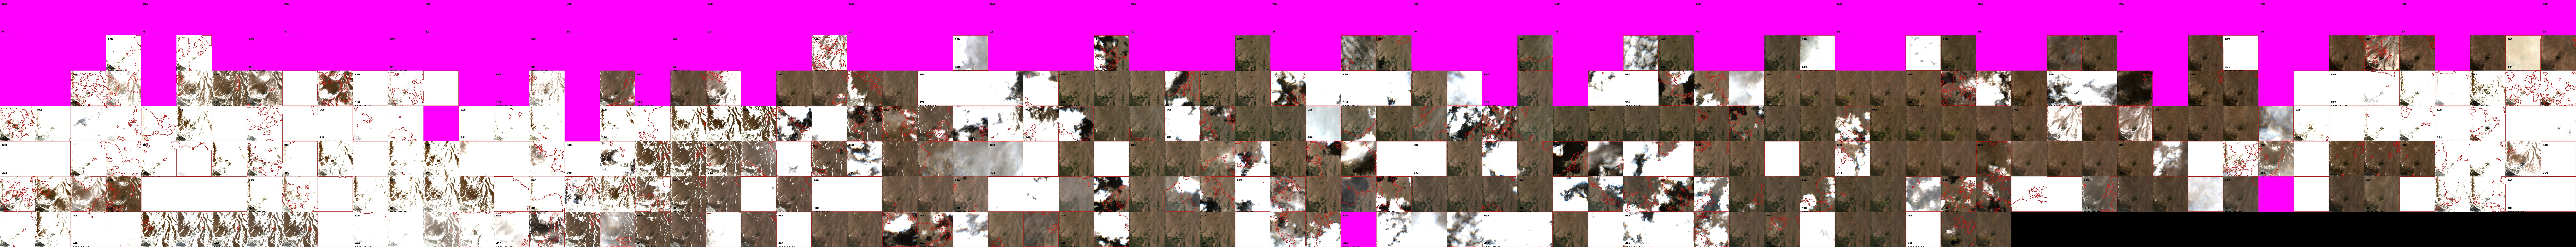

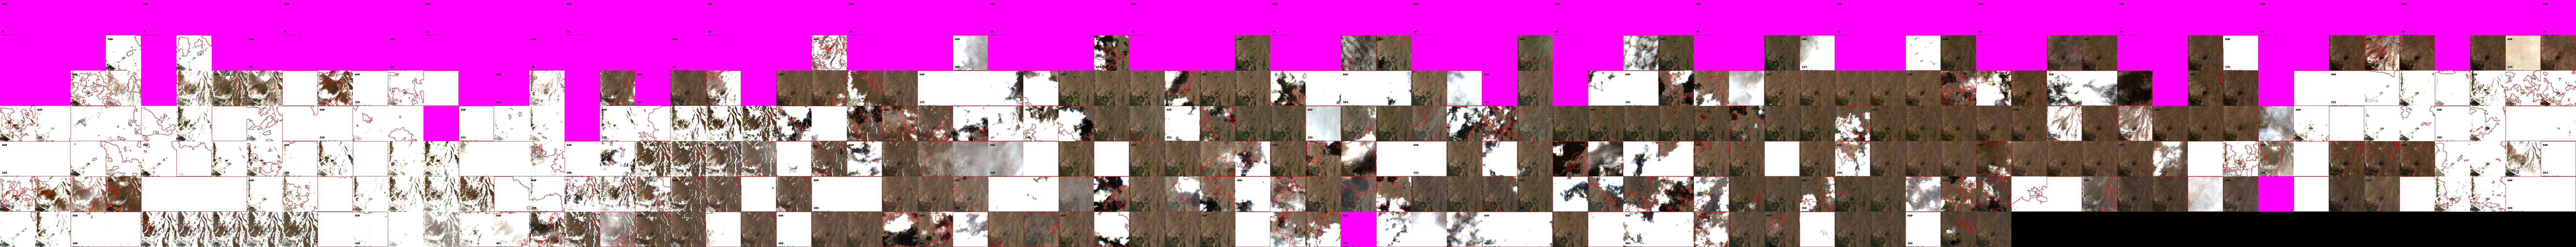

In [20]:
from IPython.display import display, Image, HTML
for image in Path('./').glob('*.jpg'):
    display(HTML(f'<h3>{image}</h3>'))
    display(Image(image))

Watch as a video (some formats might not be supported)

In [21]:
from IPython.display import Video, display, HTML, Image
for video in conversion_rules.keys():
    display(HTML(f'<h3>{video}</h3>'))
    display(Video(Path(output_path) / array_id / f'{video}.mkv', width=512, height=512))